# Appalachian Knickpoint Analyses for Geoscience
By - Nick Lewis.\
Advisors - Joanmarie Del Vecchio, Chuck Bailey.

# Code begins here!

#### Below is a 'code cell'.  This is a block of text that Jupyter and Python use to perform tasks.

#### To run the following code cell and all code cells below, select the cell and press
# <p style="color: aqua;">Shift+Enter.</p>

In [ ]:
# This is called a comment.  Denoted by the '#' behind the text, it allows me to better explain code cells while still being a begign line of text.

# First, we import the YML file.  This saves you the work of making your own python environment and installing a bunch of packages.
#!conda env create -f env.yml

In [ ]:
# From google drive, let's get the peripheral files our code will use.
#function here that imports shit

In [4]:
# Import packages to our notebook.
# We must do this to use the functions contained inside the packages.
# Some functions have 'as' in the import call.  This is for less typing, and nothing else.
# Google any package name and 'docs' in order to find more detailed explanation of any one package.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import geopandas as gpd
import xdem
import os
import rasterio as rio
from rasterio.plot import show
import glob
from concurrent.futures import ThreadPoolExecutor
import requests
import shapely
import time
from tqdm import tqdm

#### Phew!  That was a lot of initial stuff, but no worries.  We can start *really* coding now.

#### Below is a code cell containing our **Constant** Variables, which you may change as you see fit for your particular analyses.

#### Below are 
- Integers
- Lists (denoted by square brackets at the beginning and end, separated by commas [a, b, c, d])
- Strings (contained within quotes 'Like this!')

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.0, -80.0, 37.5, -81.5] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available area goes down.

PROJ_TITLE = 'n_lewis' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

#### If you can't remember what a function does, call the help() function and pass the name of the function you are wondering about inside the colons.

# First,
#### We download a DEM of the user selected area.

Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/n_lewis" already exists.
Querying API...
URL passed, now waiting for file to write.
File Written.
Plotting...


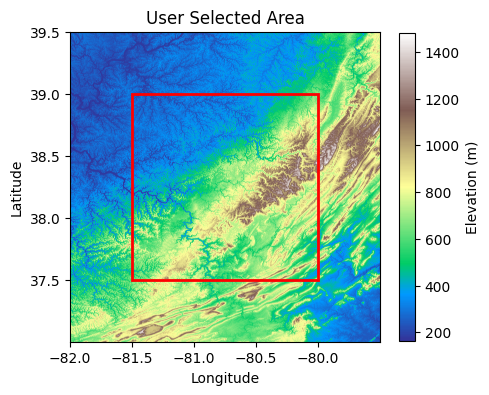

In [3]:
# Downloader
def downloader(bounds:list = BOUNDS, api_key:str = API_KEY, dem_dataset:str = DEM_DATASET, proj_title:str = PROJ_TITLE, path:str = PATH): # To call a function, we have to define it first.
    """
    This function takes in the user-defined constants and creates a directory.  It then places a geotiff in the directory.

    args: Bounds (list), api_key (str), dem_dataset (str), proj_title (str).

    returns: None.
    """

    # First, we make our directory for project files.
    try:
        os.mkdir(path = f'{path}/{proj_title}')
        print(f'Directory "{path}/{proj_title}" created successfully.') # Tries to make the directory for project files.
        proj_dir = f'{path}/{proj_title}'
    except FileExistsError:
        print(f'Directory "{path}/{proj_title}" already exists.') # If it doesnt work, it'll tell you!
        proj_dir = f'{path}/{proj_title}'
    except Exception as e:
        print(f'An error occurred: {e}')

    # Now to download our dem.
    dic = dict(zip(['north', 'east', 'south', 'west'], bounds)) # Makes a dictionary to let us more easily acess our bounds.
    url = f'https://portal.opentopography.org/API/usgsdem?datasetName={dem_dataset}&south={dic["south"]-0.5}&north={dic["north"]+0.5}&west={dic["west"]-0.5}\
&east={dic["east"]+0.5}&outputFormat=GTiff&API_Key={api_key}' # Creates our URL so we can download.
    print('Querying API...')
    response = requests.get(url) # Saves what the URL spit back at us
    print('URL passed, now waiting for file to write.')
    with open(f'{proj_dir}/gtiff.tiff', 'wb') as file:
        file.write(response.content) # Writes the response to our project file
    print('File Written.')

    # Plotting
    print('Plotting...')
    fig, ax = plt.subplots(figsize=(5,5)) # Creates our figure object.
    ax.set_title('User Selected Area')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    with rio.open(f'{path}/{proj_title}/gtiff.tiff') as src: # Add in the basemap.
        basemap = show(src, cmap='terrain', ax=ax)
    im = basemap.get_images()[0]
    fig.colorbar(im, ax=ax, label='Elevation (m)', location='right', shrink=0.8) # Add colorbar
    bbox = patches.Rectangle((bounds[1],bounds[2]), width=(bounds[3]-bounds[1]), height=(bounds[0]-bounds[2]), linewidth=2, edgecolor='r', facecolor='none') # Add in bounding box from user.
    ax.add_patch(bbox)

    plt.show()

downloader() # Here, we call the function.

# Next,
#### We will clip out each watershed in your selected area.

In [5]:
# Wshed Clipper
def wshed_clipper(proj_title = PROJ_TITLE, bounds = BOUNDS, path = PATH):
    """
    
    """
    # PLACEHOLDER - Line to download wsheds csv
    # df = pd.read_csv(f'{os.getcwd}/{proj_title}/wsheds.csv') # We read in our wshed data
    print('Loading data...')
    df = pd.read_csv('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/wbd_scale/WBDHU10.csv') 
    gdf = gpd.GeoDataFrame(data=df, crs=rio.CRS.from_epsg(4269), geometry=[shapely.wkt.loads(x) for x in df['geometry']]) # We turn it into a geodataframe to do geospatial stuff to.
    clipped = gpd.GeoDataFrame(gdf.cx[bounds[3]:bounds[1], bounds[2]:bounds[0]]) # Clip it to the user's bounds.

    # Now that we have a GDF (GeoDataFrame) with the user's chosen watersheds and the larger dem, lets export DEMs of each watershed.
    try:
        os.mkdir(path = f'{path}/{proj_title}/wshed_dems') # Makes a directory to store these new dems.
        print(f'Directory "{path}/{proj_title}/wshed_dems" created successfully.') # Tries to make the directory for project files.
    except FileExistsError:
        print(f'Directory "{path}/{proj_title}/wshed_dems" already exists.') # If it doesnt work, it'll tell you!
    except Exception as e:
        print(f'An error occurred: {e}')
    
    # We have our directory, lets populate it.
    print('Writing new DEMs...')
    with rio.open(f'{path}/{proj_title}/gtiff.tiff') as src: # Loads in our larger df.
        total_tasks=len(clipped)
        with tqdm(total=total_tasks, desc='Progress') as pbar: # This is for the fancy progress bar.

            for idx, row in clipped.iterrows(): # Iterate through the watershed dataframe (for each row, do something.)
                name = row['name'].replace(' ', '_') # Replaces spaces with underscores and saves the name to a variable.

                geom = row['geometry'] # Saves our geometry to a variable.

                out_image, out_transform = rio.mask.mask(src, geom.geoms, crop=True) # Clips the DEM to our watershed's shape.  Sets nodata value to LSDTopyTools standard.

                # Below is metadata stuff, dont stress about this.
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                    })

                out_path = f'{path}/{proj_title}/wshed_dems/{name}.tiff' # Create a pathname.
                with rio.open(out_path, "w", **out_meta) as file:
                    file.write(out_image) # Write to file.
                pbar.update(1)

# Call our function, let it do the work.           
wshed_clipper()

Loading data...
Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/n_lewis/wshed_dems" created successfully.
Writing new DEMs...


Progress: 100%|██████████| 67/67 [00:07<00:00,  9.14it/s]


# Next,
#### Lets find what we call 'LSHT' (low slope, high topography) terrain.  This will serve as the area not yet affected by our (possibly) migrating knickpoints

In [6]:
# LSHT
def lsht(dem_dir=f'{PATH}/{PROJ_TITLE}/wshed_dems'):
    """

    """
    path_list = glob.glob(f'{dem_dir}/*.tiff') # Create a list of all the paths to our watershed DEMs.
    
    def df_maker(path):
        dem = xdem.DEM(path) # Load in the DEM.
        tri = dem.terrain_ruggedness_index(window_size=3) # Make an SLRM (Simple Local Relief Model) of the DEM.  3 pix window size.

        # Next we are going to find the 10th percentile relief for the dem.
        t_data = tri.data # Get our data.
        t_data = np.asarray(t_data)
        t_valid_mask = ~np.isnan(t_data)
        t_valid = t_data[t_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_10th = np.percentile(t_valid, 10) # From valid values, get 10th percentile.
        t_bool_mask = np.where(t_valid_mask & (t_data < perc_10th), True, False) # True if data is valid and below 10th percentile. False otherwise.

        # We now repeat the process to find the 90th percentile elevation.
        e_data = dem.data
        e_data = np.asarray(e_data)
        e_valid_mask = ~np.isnan(e_data)
        e_valid = e_data[e_valid_mask] # Create a mask that is false if it is nan.  Extract valid values.
        perc_90th = np.percentile(e_valid, 90) # From valid values, get 10th percentile.
        e_bool_mask = np.where(e_valid_mask &  (e_data > perc_90th), True, False)

        # Get the name for our export csv.
        name = path.split(sep='/')
        name = name[-1][:-5]

        # Create our df.
        # First get our coordinate values.
        nrows, ncols = tri.data.shape
        rows, cols = np.indices((nrows, ncols))
        xs, ys = tri.transform * (cols, rows)

        names = [name] * len(xs.flatten())

        data = {'lon':xs.flatten(), 'lat':ys.flatten(), '10th_r':t_bool_mask.flatten(), '90th_e':e_bool_mask.flatten(), 'Wshed_name':names}
        df = pd.DataFrame(data=data)
        return df
        
    
    with ThreadPoolExecutor() as executor:
        results_iter = executor.map(df_maker, path_list)
        results = list(results_iter)

    return results

x = lsht()

# Also,
#### We can map relief for each watershed (optional, do it if you're curious!)

In [10]:
# Relief & LSHT toolbox
def map_relief(dem_dir=f'{PATH}/{PROJ_TITLE}/wshed_dems'):
    """

    """
    # Glob a list of paths to the DEMs.
    path_list = glob.glob(f'{dem_dir}/*.tiff')
 
    try:
        os.mkdir(f'{PATH}/{PROJ_TITLE}/tri_pngs')
        print(f'Directory "{PATH}/{PROJ_TITLE}/tri_pngs" made sucessfully.')
    except FileExistsError:
        print(f'Directory "{PATH}/{PROJ_TITLE}/tri_pngs" Exists')
        pass
    except Exception as e:
        print(f'An error occured: {e}')
    print('Saving figures...')
    with tqdm(total=len(path_list), desc='Progress') as pbar:
        for path in path_list:
            tri = xdem.DEM(path).terrain_ruggedness_index()
            plt.ioff()
            fig, ax = plt.subplots(dpi=250)
            _ = tri.plot(cmap='magma', ax=ax, cbar_title='Relief (m)')
            name = path.split(sep='/')[-1][:-5]
            name_no_und = name.replace('_',' ')
            ax.set_title(f'{name_no_und} Terrain Ruggedness Index')
            ax.set_ylabel('Latitude (°)')
            ax.set_xlabel('Longitude (°)')
            fig.tight_layout()
            plt.savefig(f'{PATH}/{PROJ_TITLE}/tri_pngs/{name}_TRI.png')
            plt.close()
            pbar.update(1)

map_relief()

Directory "/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/n_lewis/tri_pngs" made sucessfully.
Saving figures...


Progress: 100%|██████████| 66/66 [00:51<00:00,  1.28it/s]


In [ ]:
# Kept to show how wshed dataset was narrowed.  U10 scale and only regions in the appalachians.
#apps = gdf.cx[-87:-58, 32:49]
#apps.to_csv('/sciclone/home/ntlewis/Nick-Lewis-Research/working_files/data/wbd_scale/WBDHU10.csv')